In [2]:
import pandas as pd

In [4]:
### Get accessions of all mammals in the data 
d = pd.read_csv('../mitochondrial_metazoa_counts_93.tsv', sep="\t")
c = pd.read_csv('../species_descriptions_with_common_name.csv')

In [145]:
### Get genbanks of these accessions 

from Bio import Entrez
from Bio import SeqIO
from collections import defaultdict

Entrez.email = "acritschristoph@jhu.edu"

rrnas = defaultdict(list)

handle = Entrez.efetch(db="nuccore",
                       id=c.Contig.to_list(),
                       rettype="gb",
                       retmode="text")

for whole_sequence in SeqIO.parse(handle, "genbank"):

    for feature in whole_sequence.features:
        if feature.type == 'rRNA':
            rrnas[whole_sequence.id].append(feature.location)

In [48]:
for contig in c.Contig:
    if len(rrnas[contig]) != 2:
        print(contig + "\t" + str(len(rrnas[contig])))

KX585864.1	0
CM045469.1	0
NC_056354.1	3
NC_056622.1	0
KR816507.1	0
JX181763.1	1
NC_025503.1	0


In [68]:
## None of the above are mammals except for KR816507 which is Hystrix brachurya. We can hand label the rRNA in this case.
rrna_positions = defaultdict(list)

rrna_positions['KR816507.1'].append((69,2669)) # from https://www.ncbi.nlm.nih.gov/nucleotide/NC_050263.1

for contig in rrnas:
    total_ignored = 0
    
    positions = []
    if len(rrnas[contig]) == 2:
        for feature in rrnas[contig]:
            positions.append((int(feature.start),int(feature.end)))
            total_ignored += int(feature.end) -int(feature.start)
    
    if total_ignored > 500 and total_ignored < 3000:
        rrna_positions[contig] = positions
    else:
        print(contig + "\t" + str(total_ignored))
        
### None of the list below of oddballs are mammals

NC_056354.1	0
JX181763.1	0
NC_000933.1	3271
KX585864.1	0
CM045469.1	0
NC_056622.1	0
KR816507.1	0
NC_025503.1	0
NC_025580	0


In [146]:
f = open('rrna_positions.tsv', 'w+')
for contig in rrna_positions:
    for pos in rrna_positions[contig]:
        f.write(contig + "\t" + str(pos[0]) + "\t" + str(pos[1]) + "\n")
f.close()

In [30]:
### Count reads mapping to non-rRNA regions
r = pd.read_csv('./mt93_counts_rrna.tsv', sep="\t")

prior = pd.read_csv('../mitochondrial_metazoa_counts_93.tsv', sep="\t")
del prior['Lab code']
del prior['Sample_category']
del prior['Stall_corrected']
del prior['Sample_Name']

new_columns = []
for column in prior.columns:
    if column == 'Run':
        new_columns.append("Sample_Name")
    else:
        new_columns.append(column.split()[0])
    
prior.columns = new_columns

r = r.melt(id_vars='Sample_Name')

prior = prior.melt(id_vars='Sample_Name')


In [31]:
final = pd.merge(r, prior, on=['Sample_Name','variable'])
final['diff'] = (final['value_y']+1) / (final['value_x']+1)
metadata = d[['Run','Lab code','Sample_category']]
final = pd.merge(final,metadata,left_on='Sample_Name',right_on='Run')

Text(0.5, 0, 'Mitochondrial reads (excluding 16S and 12S)')

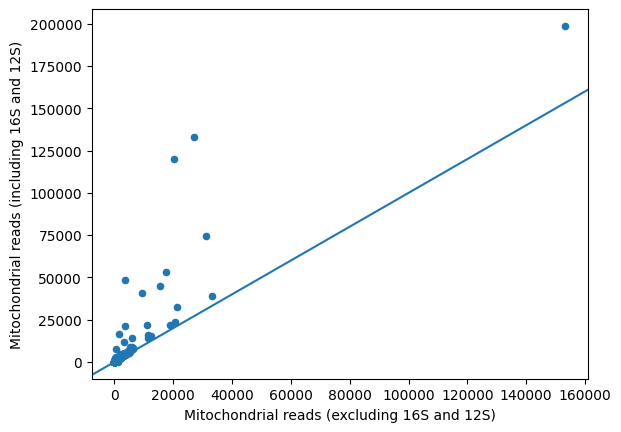

In [33]:
import matplotlib.pyplot as plt

ax = final.plot.scatter("value_x","value_y")
ax.axline((0, 0), slope=1)
# plt.xscale("log")
# plt.yscale("log")
# plt.xlim(0,1000)
# plt.ylim(0,1000)
plt.ylabel("Mitochondrial reads (including 16S and 12S)")
plt.xlabel("Mitochondrial reads (excluding 16S and 12S)")

In [34]:
final['diff'] = 1 - (final['value_x'] / final['value_y'])

In [35]:
d = pd.read_csv('../species_descriptions_with_common_name.csv')

In [36]:
final = pd.merge(final, d[['Contig','Species','Class']], left_on =  'variable', right_on = 'Contig')

Text(0.5, 0, 'Mitochondrial reads (excluding 16S and 12S)')

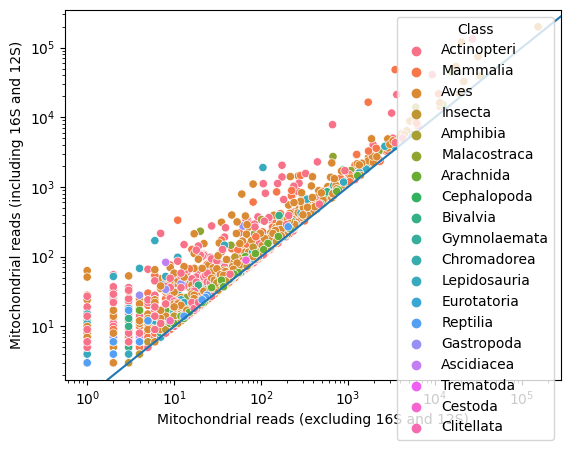

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.scatterplot(final, x="value_x",y="value_y", hue='Class')
ax.axline((0, 0), slope=1)
plt.xscale("log")
plt.yscale("log")
# plt.xlim(0,1000)
# plt.ylim(0,1000)
plt.ylabel("Mitochondrial reads (including 16S and 12S)")
plt.xlabel("Mitochondrial reads (excluding 16S and 12S)")

In [38]:
m = final.query("Class == 'Mammalia'")

In [39]:
good = m[m.Species.isin(['Hystrix brachyura','Homo sapiens','Paguma larvata','Nyctereutes procyonoides','Canis lupus','Erinaceus amurensis', 'Rhizomys pruinosus'])]

In [40]:
good2 = good[good.Sample_category.isin(['market_stall_wildlife','market_west_Jan1','market_629_Jan12','market_825'])]

Text(0.5, 0, 'Mitochondrial reads (excluding 16S and 12S)')

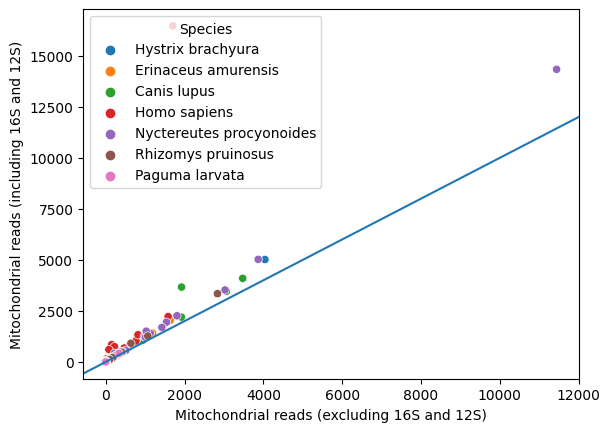

In [41]:
ax = sns.scatterplot(good2, x="value_x",y="value_y", hue='Species')
ax.axline((0, 0), slope=1)
# plt.xscale("log")
# plt.yscale("log")
# plt.xlim(0,1000)
# plt.ylim(0,1000)
plt.ylabel("Mitochondrial reads (including 16S and 12S)")
plt.xlabel("Mitochondrial reads (excluding 16S and 12S)")

HJ200062-20200112-1


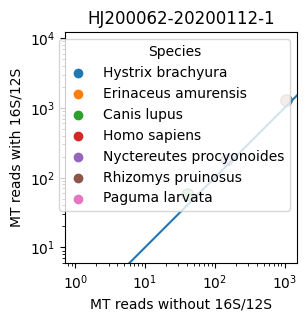

HJ200063-20200112-1


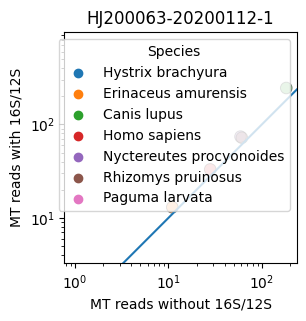

HJ200065-20200112-1


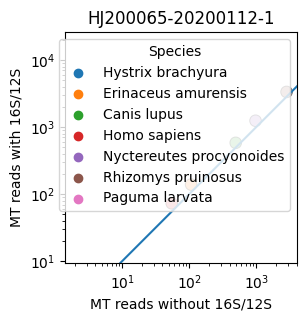

HJ200066-20200112-1


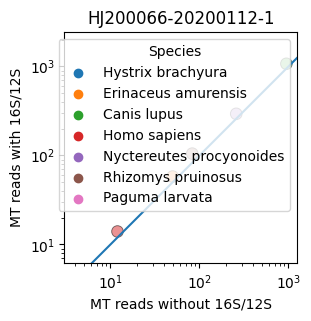

HJ200067-20200112-1


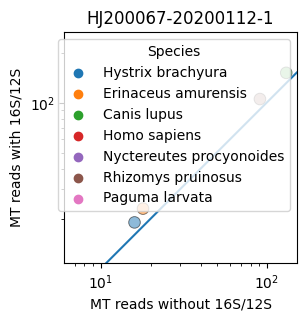

Q61


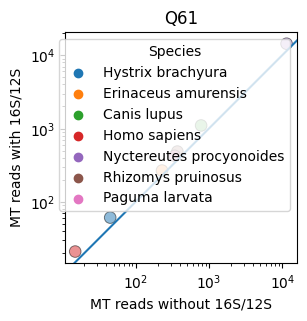

Q64


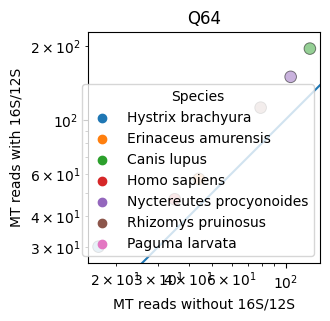

Q68


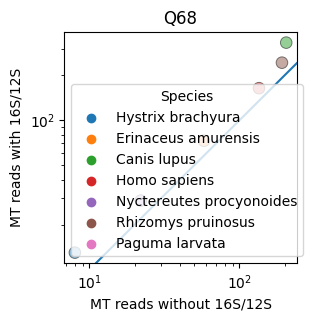

Q69


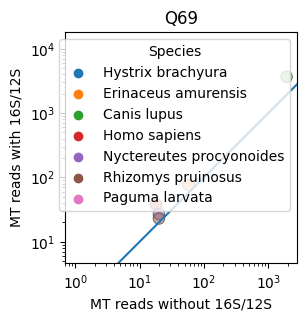

Q70


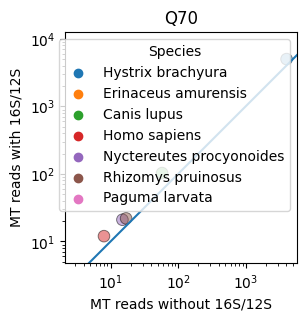

In [43]:
plt.rcParams['svg.fonttype'] = 'none'

for labcode in good[good.Sample_category == 'market_629_Jan12']['Lab code'].unique():
    print(labcode)
    
    plt.rcParams["figure.figsize"] = (3,3)
    
    ax = sns.scatterplot(good[good['Lab code'] == labcode], x="value_x",y="value_y", hue='Species', s=70, edgecolor='black', alpha=0.5)
    ax.axline((0, 0), slope=1)
    plt.yscale("log")
    plt.xscale("log")
    plt.axis('equal')
    plt.title(labcode)
    # plt.legend([],[], frameon=False)
    plt.ylabel("MT reads with 16S/12S")
    plt.xlabel("MT reads without 16S/12S")
    plt.savefig(labcode + "_rrna.svg")
    plt.show()